2022.06.09 - 2022.06.15

hierarchical clustering

1. linkage 방법 바꾸기
    * average
    * ward    
2. 군집 더 많이 쪼개기 (눈으로 봤을 때 라벨 분포 특징이 보이는 군집이 나누어지도록) 
3. 2번에서 정한 특정 군집을 1, 나머지를 0으로 하여 학습 후 feature importance 
4. 차트 확인 (패턴이 보이면 추가)
5. 그룹 별 라벨 비율 조사

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.input_area pre {font-family: Consolas; font-size: 15pt; line-height: 140%; font-weight: bold}</style>"))
display(HTML("<style>.output_area pre {font-family: Consolas; font-size: 15pt; line-height: 140%;}</style>"))

In [1]:
import pickle
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import preprocessing
import pandas as pd
import os
import time, os
import pymysql
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import ta
import warnings
import seaborn as sns
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 600)

warnings.filterwarnings(action='ignore')



%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15,7)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from itertools import combinations
len(list(combinations(range(5000), 2)))

12497500

# CCI

## 평가지표 함수 

In [4]:
def plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob):
    from sklearn.metrics import roc_curve, roc_auc_score, f1_score, f1_score, accuracy_score, recall_score, precision_score
    
    fpr, tpr, thresholds = roc_curve(testY, test_prob) # output 3개가 나오는데, 각 threshhold 마다의 fpr, tpr값 인듯
    
    train_f1 = f1_score(trainY, train_pred)
    test_f1 = f1_score(testY, test_pred)
    
    train_recall = recall_score(trainY, train_pred)
    test_recall = recall_score(testY, test_pred)
    
    
    train_pre = precision_score(trainY, train_pred)
    test_pre = precision_score(testY, test_pred)  
    
    train_acc = accuracy_score(trainY, train_pred)
    test_acc = accuracy_score(testY, test_pred)
    
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('test ROC : {}'.format(round(roc_auc_score(testY, test_prob),3)),fontsize=25)
    plt.legend()
    plt.show()
    print('train_f1 score: ',train_f1)
    print('test_f1 score: ',test_f1,'\n')
    
    print('train_recall score: ',train_recall)
    print('test_recall score: ',test_recall,'\n')

    print('train_pre score: ',train_pre)
    print('test_pre score: ',test_pre,'\n')
    
    print('train acc score: ',train_acc)
    print('test acc score: ',test_acc, '\n')

## 2019-2021 데이터 로드 

### data2019 로드 

In [5]:
import pickle
with open('./year_data/data2019_X.pickle', 'rb') as f:
    data2019_X = pickle.load(f)

In [6]:
import pickle
with open('./year_data/data2019_Y.pickle', 'rb') as f:
    data2019_Y = pickle.load(f)

In [7]:
import pickle
with open('./year_data/lst_2019_nc.pickle', 'rb') as f:
    lst_2019_nc = pickle.load(f)

In [8]:
import pickle
with open('./year_data/lst_2019_cd.pickle', 'rb') as f:
    lst_2019_cd = pickle.load(f)

In [9]:
import pickle
with open('./year_data/lst_2019_dt.pickle', 'rb') as f:
    lst_2019_dt = pickle.load(f)

### data2020 로드 

In [10]:
import pickle
with open('./year_data/data2020_X.pickle', 'rb') as f:
    data2020_X = pickle.load(f)

In [11]:
import pickle
with open('./year_data/data2020_Y.pickle', 'rb') as f:
    data2020_Y = pickle.load(f)

In [12]:
import pickle
with open('./year_data/lst_2020_nc.pickle', 'rb') as f:
    lst_2020_nc = pickle.load(f)

In [13]:
import pickle
with open('./year_data/lst_2020_cd.pickle', 'rb') as f:
    lst_2020_cd = pickle.load(f)

In [14]:
import pickle
with open('./year_data/lst_2020_dt.pickle', 'rb') as f:
    lst_2020_dt = pickle.load(f)

### data2021 로드 

In [15]:
import pickle
with open('./year_data/data2021_X.pickle', 'rb') as f:
    data2021_X = pickle.load(f)

In [16]:
import pickle
with open('./year_data/data2021_Y.pickle', 'rb') as f:
    data2021_Y = pickle.load(f)

In [17]:
import pickle
with open('./year_data/lst_2021_nc.pickle', 'rb') as f:
    lst_2021_nc = pickle.load(f)

In [18]:
import pickle
with open('./year_data/lst_2021_cd.pickle', 'rb') as f:
    lst_2021_cd = pickle.load(f)

In [19]:
import pickle
with open('./year_data/lst_2021_dt.pickle', 'rb') as f:
    lst_2021_dt = pickle.load(f)

### 데이터 개수 확인 

In [20]:
print('====2019 data====')
print(data2019_X.shape)
print(data2019_Y.shape)
print()
print('====2020 data====')
print(data2020_X.shape)
print(data2020_Y.shape)
print()
print('====2021 data====')
print(data2021_X.shape)
print(data2021_Y.shape)

====2019 data====
(60912, 560)
(60912,)

====2020 data====
(71133, 560)
(71133,)

====2021 data====
(64768, 560)
(64768,)


In [21]:
count=sum(data2019_Y==1)
print("{:=^50}".format(" data2019_Y 의 label "))
print("1의 개수:{}, 0의 개수:{}, 1의 비율:{}".format(count, len(data2019_Y)-count, (count/len(data2019_Y))))

count=sum(data2020_Y==1)
print("{:=^50}".format(" data2020_Y 의 label "))
print("1의 개수:{}, 0의 개수:{}, 1의 비율:{}".format(count, len(data2020_Y)-count, (count/len(data2020_Y))))

count=sum(data2021_Y==1)
print("{:=^50}".format(" data2021_Y 의 label "))
print("1의 개수:{}, 0의 개수:{}, 1의 비율:{}".format(count, len(data2021_Y)-count, (count/len(data2021_Y))))

=============== data2019_Y 의 label ===============
1의 개수:10026, 0의 개수:50886, 1의 비율:0.16459810874704492
=============== data2020_Y 의 label ===============
1의 개수:15843, 0의 개수:55290, 1의 비율:0.22272363038252288
=============== data2021_Y 의 label ===============
1의 개수:12799, 0의 개수:51969, 1의 비율:0.19761301877470355


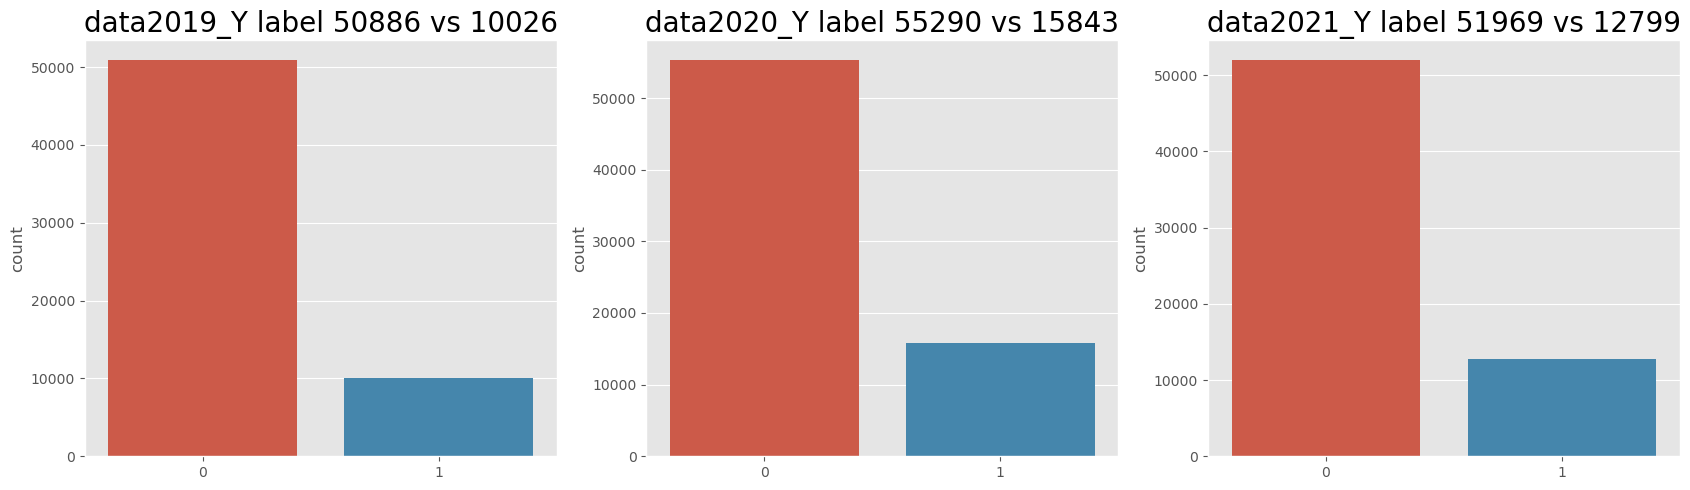

In [22]:
import seaborn as sns

plt.style.use('ggplot')
fig = plt.figure(figsize=(17, 5), dpi=100)
ax1, ax2, ax3 = fig.subplots(1, 3).flatten()

sns.countplot(list(map(int,data2019_Y)), ax=ax1)
sns.countplot(list(map(int,data2020_Y)), ax=ax2)
sns.countplot(list(map(int,data2021_Y)), ax=ax3)

ax1.set_title(f"data2019_Y label {list(data2019_Y).count(0)} vs {list(data2019_Y).count(1)}", fontsize=20)
ax2.set_title(f"data2020_Y label {list(data2020_Y).count(0)} vs {list(data2020_Y).count(1)}", fontsize=20)
ax3.set_title(f"data2021_Y label {list(data2021_Y).count(0)} vs {list(data2021_Y).count(1)}", fontsize=20)


plt.tight_layout()
plt.show()

## xgb model 로드

__xgb.model 은 train(2017-2020), test(2021) 데이터셋으로 학습된 모델__

In [102]:
# xgb.model은 train, test 데이터로 학습된 모델
xgb_model = pickle.load(open('xgb.model', 'rb'))

data2019_prob = xgb_model.predict_proba(data2019_X)[:, 1]
data2019_pred = xgb_model.predict(data2019_X)
data2020_prob = xgb_model.predict_proba(data2020_X)[:, 1]
data2020_pred = xgb_model.predict(data2020_X)
data2021_prob = xgb_model.predict_proba(data2021_X)[:, 1]
data2021_pred = xgb_model.predict(data2021_X)

# plot_roc_curve(trainY, data2019_Y, train_pred, data2019_pred, train_prob, data2019_prob)
# plot_roc_curve(trainY, data2020_Y, train_pred, data2020_pred, train_prob, data2020_prob)
# plot_roc_curve(trainY, data2021_Y, train_pred, data2021_pred, train_prob, data2021_prob)

## shap_values 로드

In [24]:
import pickle
with open('./year_data/shap_values_2019.pickle', 'rb') as f:
    shap_values_2019 = pickle.load(f)

In [25]:
import pickle
with open('./year_data/shap_values_2020.pickle', 'rb') as f:
    shap_values_2020 = pickle.load(f)

In [26]:
import pickle
with open('./year_data/shap_values_2021.pickle', 'rb') as f:
    shap_values_2021 = pickle.load(f)

In [27]:
shap_values_2019

array([[-8.1797590e-04,  1.2147729e-03, -2.6276656e-03, ...,
        -1.7179666e-02, -3.9524059e-03, -3.1026138e-02],
       [-3.1991120e-04, -2.3730358e-03, -1.7179748e-03, ...,
        -1.4247073e-02, -3.9686523e-03, -3.2220203e-02],
       [ 2.3887926e-03,  1.2087757e-03,  1.7457614e-05, ...,
        -1.4607704e-02, -3.7441878e-03, -3.2678436e-02],
       ...,
       [ 4.2637661e-03,  6.2935805e-04, -2.7945342e-03, ...,
        -8.3074206e-03,  5.9841317e-05,  7.5600920e-03],
       [-2.1647597e-03,  4.0139936e-04, -1.0904313e-02, ...,
        -1.1296561e-02, -1.1214738e-03,  2.1652561e-02],
       [-1.7535049e-03,  4.9520552e-04, -3.3527263e-03, ...,
        -1.6243216e-02, -1.3609962e-03,  2.0448830e-02]], dtype=float32)

### 컬럼 리스트

In [28]:
# 컬럼 리스트 생성
lst_col_info = []

for day in range(9, -1, -1): 
    lst_col_info += 'D-{0}_Open,D-{0}_High,D-{0}_Low,D-{0}_Close,D-{0}_Trading,D-{0}_MA5,D-{0}_MA20,D-{0}_MA60,D-{0}_MA120,D-{0}_VMAP,D-{0}_BHB,D-{0}_BLB,D-{0}_KCH,D-{0}_KCL,D-{0}_KCM,D-{0}_DCH,D-{0}_DCL,D-{0}_DCM,D-{0}_SMA,D-{0}_EMA,D-{0}_WMA,D-{0}_Ichimoku,D-{0}_Parabolic SAR,D-{0}_KAMA,D-{0}_MACD,D-{0}_Change,D-{0}_Volume,D-{0}_MFI,D-{0}_ADI,D-{0}_OBV,D-{0}_CMF,D-{0}_FI,D-{0}_EOM_EMV,D-{0}_VPT,D-{0}_NVI,D-{0}_ATR,D-{0}_UI,D-{0}_ADX,D-{0}_-VI,D-{0}_+VI,D-{0}_TRIX,D-{0}_MI,D-{0}_CCI,D-{0}_DPO,D-{0}_KST,D-{0}_STC,D-{0}_RSI,D-{0}_SRSI,D-{0}_TSI,D-{0}_UO,D-{0}_SR,D-{0}_WR,D-{0}_AO,D-{0}_ROC,D-{0}_PPO,D-{0}_PVO'.format(day).split(',')

### [origin] numpy -> dataframe 

In [29]:
##### 2019
df_data2019_X = pd.DataFrame(data2019_X)
df_data2019_X.columns = lst_col_info
df_data2019_Y = pd.DataFrame(data2019_Y)

##### 2020 
df_data2020_X = pd.DataFrame(data2020_X)
df_data2020_X.columns = lst_col_info
df_data2020_Y = pd.DataFrame(data2020_Y)

##### 2021
df_data2021_X = pd.DataFrame(data2021_X)
df_data2021_X.columns = lst_col_info
df_data2021_Y = pd.DataFrame(data2021_Y)

df_data2019_X.head()

D-9_Open  D-9_High   D-9_Low  D-9_Close    D-9_Trading   D-9_MA5  D-9_MA20  \
0  1.000000  1.016176  0.985294   0.985294  197242.088235  0.973824  1.002279   
1  1.000000  1.007463  0.977612   1.007463  108373.768657  0.997910  1.011493   
2  0.989630  1.025185  0.977778   0.989630  267000.094815  0.997926  0.996889   
3  0.998540  1.016058  0.998540   1.007299  232481.649635  1.003212  0.986496   
4  1.010145  1.031884  0.994203   1.031884  269047.257971  1.003188  0.982029   

   D-9_MA60  D-9_MA120  D-9_VMAP   D-9_BHB   D-9_BLB   D-9_KCH   D-9_KCL  \
0  1.095784   1.226446  1.005579  1.082598  0.921961  1.055760  0.964730   
1  1.109254   1.241082  1.021685  1.077226  0.945759  1.064726  0.972786   
2  1.098469   1.224037  1.013063  1.044128  0.949649  1.049432  0.957877   
3  1.072092   1.186788  0.986107  1.027004  0.945988  1.033747  0.950681   
4  1.061329   1.175097  0.982452  1.028292  0.935766  1.026473  0.946184   

    D-9_KCM   D-9_DCH   D-9_DCL   D-9_DCM   D-9_SMA   D-9_EMA   D-9_WMA  \
0  1.010245  1.132353  0.935294  1.017647  0.987868  0.992065  0.980033   
1  1.018756  1.116418  0.949254  1.026866  1.002612  1.006963  0.996153   
2  1.003654  1.108148  0.942222  1.019259  0.993580  0.998049  0.991704   
3  0.992214  1.091971  0.928467  0.988321  0.988078  0.994929  0.998508   
4  0.986329  1.084058  0.921739  0.990580  0.988406  0.994514  1.000419   

   D-9_Ichimoku  D-9_Parabolic SAR  D-9_KAMA  D-9_MACD  D-9_Change  \
0      1.031618           1.049442  0.995813 -0.035059   -0.014706   
1      1.047015           1.055838  1.010651 -0.032900    0.007463   
2      1.017407           1.035556  1.002422 -0.028755   -0.010370   
3      0.999270           1.013080  0.993172 -0.014209    0.007299   
4      0.996739           1.005739  0.989309 -0.009538    0.031884   

   D-9_Volume    D-9_MFI       D-9_ADI      D-9_OBV   D-9_CMF        D-9_FI  \
0    200186.0  60.127977 -2.845400e+08  491058052.0 -0.526172  7.035211e+04   
1    107571.0  61.053379 -2.844325e+08  491165623.0 -0.500859  8.286661e+05   
2    269798.0  56.262963 -2.846460e+08  491131810.0 -0.486325 -2.089164e+06   
3    230797.0  71.222616 -2.845095e+08  491452098.0 -0.409871  4.478842e+06   
4    260734.0  76.872507 -2.842487e+08  491712832.0 -0.344287  1.203350e+07   

    D-9_EOM_EMV      D-9_VPT     D-9_NVI     D-9_ATR    D-9_UI    D-9_ADX  \
0  5.245122e+05  2894.752906  188.345846  312.862228  9.722825  18.935113   
1 -2.881818e+07 -2141.143108  189.751412  304.800640  8.813659  18.296525   
2 -5.930363e+06 -2797.905185  189.751412  309.547491  7.733905  18.397150   
3  5.199374e+05 -1013.243583  189.467145  261.816610  4.796912  18.930617   
4  8.974664e+06  9997.907606  189.467145  261.686852  3.798560  19.707766   

    D-9_-VI   D-9_+VI  D-9_TRIX     D-9_MI     D-9_CCI  D-9_DPO     D-9_KST  \
0  0.948718  1.010684 -0.537142  25.161130  -32.795876    -65.5 -121.099761   
1  0.936975  0.978992 -0.524680  25.135236  -56.403144    -17.0 -117.798710   
2  1.008639  0.946004 -0.491216  25.199347  -22.246143    221.0 -114.427532   
3  1.094801  1.006116 -0.349367  25.002574   67.759563   -257.5  -68.020251   
4  0.874233  1.049080 -0.311160  24.872436  137.562941    -96.0  -58.163755   

     D-9_STC    D-9_RSI  D-9_SRSI    D-9_TSI     D-9_UO  ...  D-0_MA20  \
0  89.141383  41.708151  0.870063 -23.647201  23.617166  ...  0.982029   
1  94.570692  43.271107  0.941878 -22.215685  33.865077  ...  0.953020   
2  98.642673  41.465898  0.788975 -20.513082  34.245441  ...  0.974140   
3  99.957584  49.196749  0.956888 -11.389444  42.822222  ...  0.982668   
4  99.978792  55.838140  1.000000  -7.921780  53.130167  ...  0.965804   

   D-0_MA60  D-0_MA120  D-0_VMAP   D-0_BHB   D-0_BLB   D-0_KCH   D-0_KCL  \
0  1.061329   1.175097  0.982452  1.028292  0.935766  1.026473  0.946184   
1  1.025702   1.135393  0.956739  0.999077  0.906962  0.996138  0.918890   
2  1.041977   1.152065  0.984007  1.024357  0.923924  1.011246  0.942908   
3  1.035687   1.131194  0

### [shap] numpy -> dataframe

In [30]:
##### 2019
df_shap_2019 = pd.DataFrame(shap_values_2019)
df_shap_2019.columns = lst_col_info

##### 2020
df_shap_2020 = pd.DataFrame(shap_values_2020)
df_shap_2020.columns = lst_col_info

##### 2021
df_shap_2021 = pd.DataFrame(shap_values_2021)
df_shap_2021.columns = lst_col_info

#### df가 맞는지 확인  - 절댓값 씌운 후 컬럼 별 합 내림차순 정렬이 summary plot과 같은지 확인 

In [31]:
pd.DataFrame(df_shap_2019.apply(lambda x: abs(x)).sum().sort_values(ascending=False)).head(10)

0
D-0_High     7792.893555
D-0_KCL      6992.355957
D-0_DCH      6340.408203
D-0_Close    1850.875244
D-0_MA120    1730.787964
D-0_Trading  1220.923462
D-0_SR       1163.227661
D-0_PVO      1100.709106
D-4_Low      1042.903687
D-0_MA5      1018.443665

# summary plot

### shap value 계산 

In [32]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb_model)

### 2019

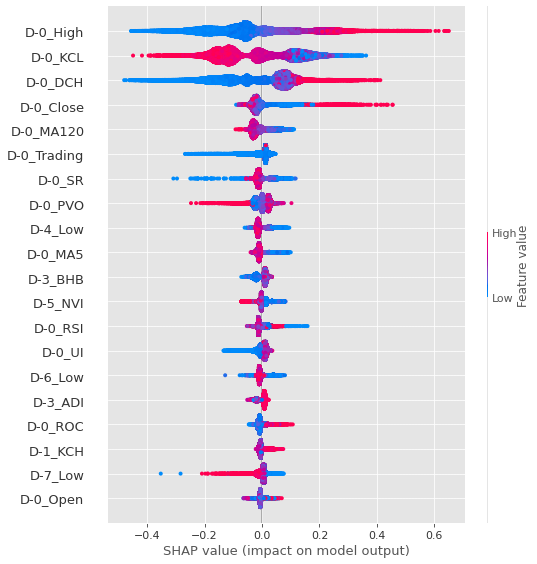

In [33]:
shap.summary_plot(shap_values_2019, df_data2019_X)

### 2020

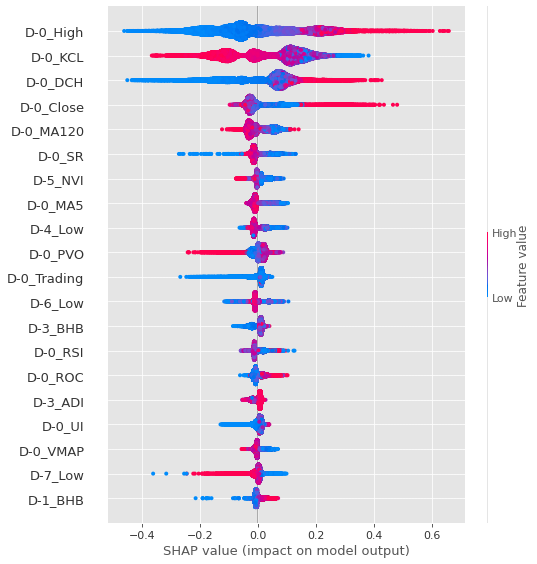

In [34]:
shap.summary_plot(shap_values_2020, df_data2020_X)

### 2021

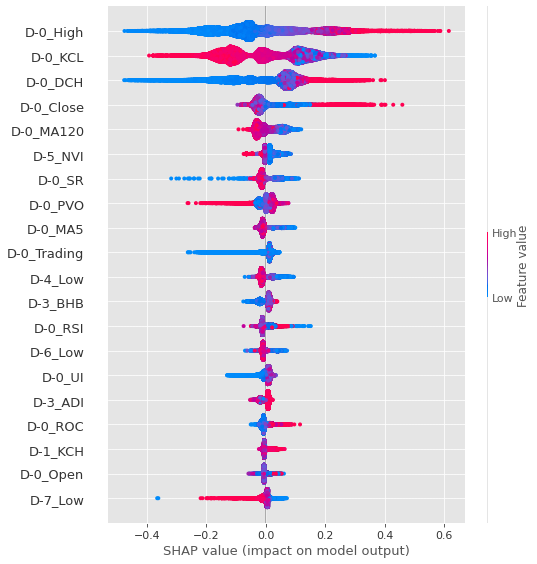

In [35]:
shap.summary_plot(shap_values_2021, df_data2021_X)

--------

# TSNE & Clustering

### __tsne__
   - 공식 문서:  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
   - 예제 참고: https://jimmy-ai.tistory.com/126

<br>

### Clustering 
#### 비계층적 군집분석, Non-Hierarchical Clustering 
예제 참고: https://yganalyst.github.io/ml/ML_clustering/ 
- __중심 기반, Center-based__ <br>
: K-means
    - 공식 문서: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


- __밀도 기반, density based__  <br>
: DBSCAN (density-based spatial clustering of applications with noise)
    - 공식 문서: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html


#### 계층적 군집분석,  hierarchical clustering

### 함수

In [36]:
plt.style.use('default')

#### tsne_plot

In [37]:
from sklearn.manifold import TSNE

def tsne_plot(np_tsne, df_data_Y, alpha=0.4, size=3):
    # numpy array -> Dataframe 
    df_tsne = pd.DataFrame(np_tsne, columns=['component0', 'component1'])

    # class target 정보 불러오기
    df_tsne['target'] = df_data_Y[0]

    # target 별 분리 
    df_tsne_0 = df_tsne[df_tsne['target']==0]
    df_tsne_1 = df_tsne[df_tsne['target']==1]

    # target 별 시각화 
    plt.scatter(df_tsne_0['component0'], df_tsne_0['component1'], color = 'green', label = 'class 0', alpha=alpha, s=size)
    plt.scatter(df_tsne_1['component0'], df_tsne_1['component1'], color = 'pink', label = 'class 1', alpha=alpha, s=size)

    plt.xlabel('component 0')
    plt.ylabel('component 1')
    plt.legend()
    plt.show()    

#### clustering_plot

In [38]:
##### 함수 수정 
def clustering_plot(method, np_tsne, dendrogram_yn='n', method_h='complete', n_clusters=5, min_samples=5, alpha=0.3, size=4):
    # method - k: kmeans, d: DBSCAN, h: hierarchical
    if method == 'k':
        from sklearn.cluster import KMeans
        import matplotlib.pyplot as plt
        km = KMeans(n_clusters = n_clusters, random_state=42)
        km.fit(np_tsne)    
        new_labels = km.labels_
        plt.title("K-means", fontsize=15)
        scatter = plt.scatter(np_tsne[:, 0], np_tsne[:, 1], c=new_labels, cmap='gist_rainbow', s=size, alpha=alpha, )
        plt.legend(*scatter.legend_elements())
        return new_labels
        
        
    elif method == 'd':
        from sklearn.cluster import DBSCAN
        import matplotlib.pyplot as plt
        clusters = DBSCAN(eps=0.3, min_samples=min_samples).fit(np_tsne)
        plt.title("DBSCAN", fontsize=15)
        scatter = plt.scatter(np_tsne[:, 0],np_tsne[:, 1],c=clusters.labels_, cmap='gist_rainbow', s=size, alpha=alpha)
        plt.grid()
        plt.legend(*scatter.legend_elements())
        plt.show()
        return clusters

    elif method == 'h':
        from scipy.cluster.hierarchy import linkage, dendrogram
        import matplotlib.pyplot as plt
        clusters = linkage(y=np_tsne, method=method_h, metric='euclidean')
        print("linkage complete")
        
#         plt.figure( figsize = (25, 10) )
        if dendrogram_yn == 'y':
            plt.title("hierarchical", fontsize=15)
            dendrogram(clusters, leaf_rotation=90, leaf_font_size=12,)
            plt.show() 
            
        return clusters 
        
    else:
        print("method를 잘못 입력하였습니다.")

#### hierarchical_clustering_plot

In [39]:
def hierarchical_clustering_plot(method, np_tsne, dendrogram_yn='n', n_clusters=5, min_samples=5, alpha=0.3, size=4):
    # method - complete, average, ward
    
    if method in ('complete', 'average', 'ward'):
        from scipy.cluster.hierarchy import linkage, dendrogram
        import matplotlib.pyplot as plt
        clusters = linkage(y=np_tsne, method=method, metric='euclidean')
        print("linkage complete")
        
        if dendrogram_yn == 'y':
            plt.title("hierarchical", fontsize=15)
            dendrogram(clusters, leaf_rotation=90, leaf_font_size=12,)
            plt.show() 
            
        return clusters 
        
    else:
        print("method를 잘못 입력하였습니다.")

#### fcluster_plot

In [40]:
def fcluster_plot(np_clusters, np_tsne, t=30, alpha=0.3, size=4):
    from scipy.cluster.hierarchy import fcluster # 지정한 클러스터 자르기
    
    cut_tree = fcluster(np_clusters, t=t, criterion='distance')
    print("군집의 개수:", len(pd.DataFrame(cut_tree)[0].unique()))
    scatter = plt.scatter(x=np_tsne[:, 0], y=np_tsne[:, 1], c=cut_tree, cmap='gist_rainbow', alpha=alpha, s=size)
    plt.legend(*scatter.legend_elements())
    
    return cut_tree

In [117]:
# 라벨 1의 비율이 ratio 이상인 군집만 뽑아 시각화 
def label_1_clustering_plot(df_shap, xlim=70,ylim=70, ratio=0.5):
    # ratio: (default) 0.5 -> 1의 비율이 0.5 이상  
    
    gb = df_shap.groupby('Cluster')['Label'].value_counts(sort=False).unstack() # 군집 별 라벨 개수
    idx_label_1 = gb[gb[1]/(gb[0]+gb[1]) > ratio].index # 라벨 1의 비율이 ratio 이상인 군집 번호
    print(f'label 1 > {ratio} 군집 번호: ', idx_label_1)
    
    df_shap_1 = df_shap[df_shap['Cluster'].isin(idx_label_1)] # 라벨 1의 비율이 ratio 이상인 군집 추출 
    plt.title(f"label 1 > {ratio}", fontsize=15)
    scatter = plt.scatter(df_shap_1['component1'],df_shap_1['component2'],c=df_shap_1['Cluster'], cmap='gist_rainbow', s=3, alpha=0.4)
    plt.legend(*scatter.legend_elements())
    plt.ylim(-ylim, ylim) # tsne 범위와 맞추기
    plt.xlim(-xlim, xlim)
    
    return df_shap_1

In [118]:
# 라벨 0의 비율이 ratio 이상인 군집만 뽑아 시각화 
def label_0_clustering_plot(df_shap, xlim=70,ylim=70, ratio=0.5):
    # ratio: (default) 0.5 -> 1의 비율이 0.5 이상  
    
    gb = df_shap.groupby('Cluster')['Label'].value_counts(sort=False).unstack()  # 군집 별 라벨 개수
    idx_label_0 = gb[gb[0]/(gb[0]+gb[1]) > ratio].index # 라벨 1의 비율이 ratio 이상인 군집 번호
    print(f'label 1 > {ratio} 군집 번호: ', idx_label_0)
    
    df_shap_0 = df_shap[df_shap['Cluster'].isin(idx_label_0)] # 라벨 0의 비율이 ratio 이상인 군집 추출 
    plt.title(f"label 0 > {ratio}", fontsize=15)
    scatter = plt.scatter(df_shap_0['component1'],df_shap_0['component2'],c=df_shap_0['Cluster'], cmap='gist_rainbow', s=3, alpha=0.4)
    plt.legend(*scatter.legend_elements())
    plt.ylim(-ylim, ylim) # tsne 범위와 맞추기
    plt.xlim(-xlim, xlim)
    
    return df_shap_0

In [119]:
# 라벨 1의 비율이 ratio 이상인 군집을 라벨 1로 하여 모델 학습 , summary plot 시각화  
def xgb_importance(df_shap, df_shap_1, year, mode='load'):
    # mode: load(저장된 모델 로드) or save(모델 학습 및 저장)
    label = np.zeros(len(df_shap)) # 라벨 초기화
    label[df_shap_1.index] = 1 # label_1_clustering_plot 함수에서 구한 군집들의 라벨을 1로 설정
    X = df_shap[lst_col_info].copy()
    y = label.copy()
    
    if mode == 'save': # 모델 학습 및 저장
        print("===start xgb===")
        from xgboost import XGBClassifier
        import pickle

        xgb_model = XGBClassifier(
                           n_jobs=40,
                           learning_rate=0.01,
                           max_depth=5,
                           n_estimators=1000,
                           ) # 임의의 값 (튜닝값 x)

        xgb_model.fit(X, y)
        pickle.dump(xgb_model, open(f'xgb.model_{year}', 'wb'))
        print("===complete xgb===")
        
    elif mode == 'load': # 모델 로드 
        import pickle
        xgb_model = pickle.load(open(f'xgb.model_{year}', 'rb'))
        
        
    print('===start shap value===')
    from xgboost import plot_importance
    plot_importance(xgb_model, max_num_features=20)

linkage method
- single
- **complete**
- average
- weighted
- centroid
- median
- ward

# hierarchical_clustering_plot

## [shap] 2019

### tsne

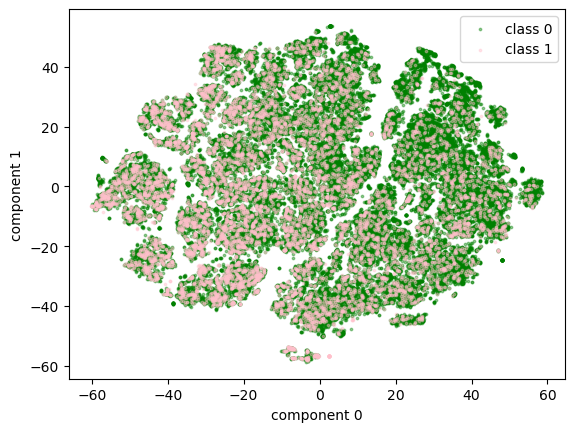

In [41]:
import pickle
with open('./year_data/np_tsne_shap_2019.pickle', 'rb') as f:
    np_tsne_shap_2019 = pickle.load(f)
    
tsne_plot(np_tsne=np_tsne_shap_2019, df_data_Y=df_data2019_Y)

### average

군집의 개수: 57


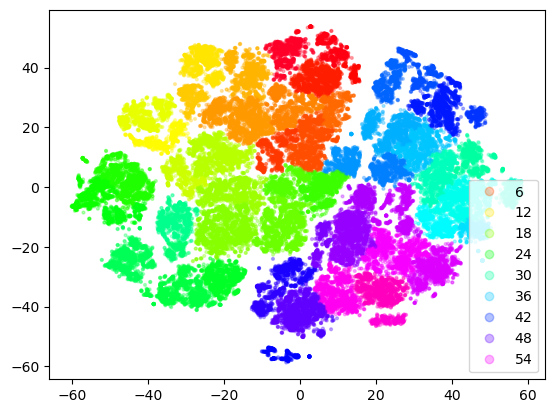

In [87]:
import pickle
with open('./year_data/clusters_avg_shap_2019.pickle', 'rb') as f:
    clusters_avg_shap_2019 = pickle.load(f)
    
cut_tree_avg_shap_2019=fcluster_plot(np_clusters=clusters_avg_shap_2019, np_tsne=np_tsne_shap_2019, t=10) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

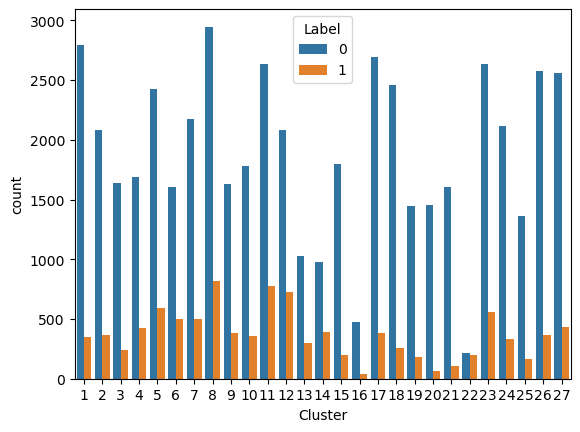

In [43]:
df_shap_2019['Code'] = lst_2019_cd
df_shap_2019['Date'] = lst_2019_dt
df_shap_2019['Label'] = df_data2019_Y[0]
df_shap_2019['Cluster'] = cut_tree_avg_shap_2019
df_shap_2019 = df_shap_2019[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_shap_2019.head()
sns.countplot(data=df_shap_2019, x='Cluster', hue='Label')

### ward

군집의 개수: 56


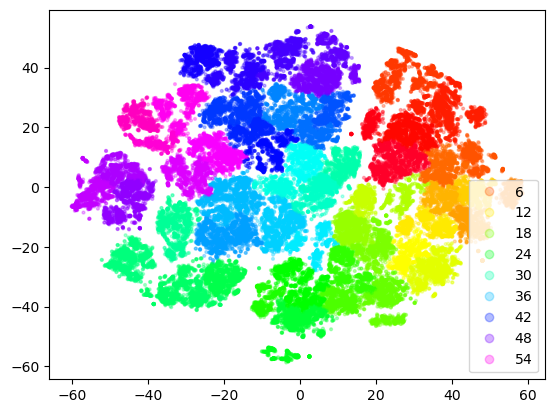

In [97]:
import pickle
with open('./year_data/clusters_ward_shap_2019.pickle', 'rb') as f:
    clusters_ward_shap_2019 = pickle.load(f)
    
cut_tree_ward_shap_2019=fcluster_plot(np_clusters=clusters_ward_shap_2019, np_tsne=np_tsne_shap_2019, t=250) # t가 작을수록 군집 개수 증가

<AxesSubplot:xlabel='count', ylabel='Cluster'>

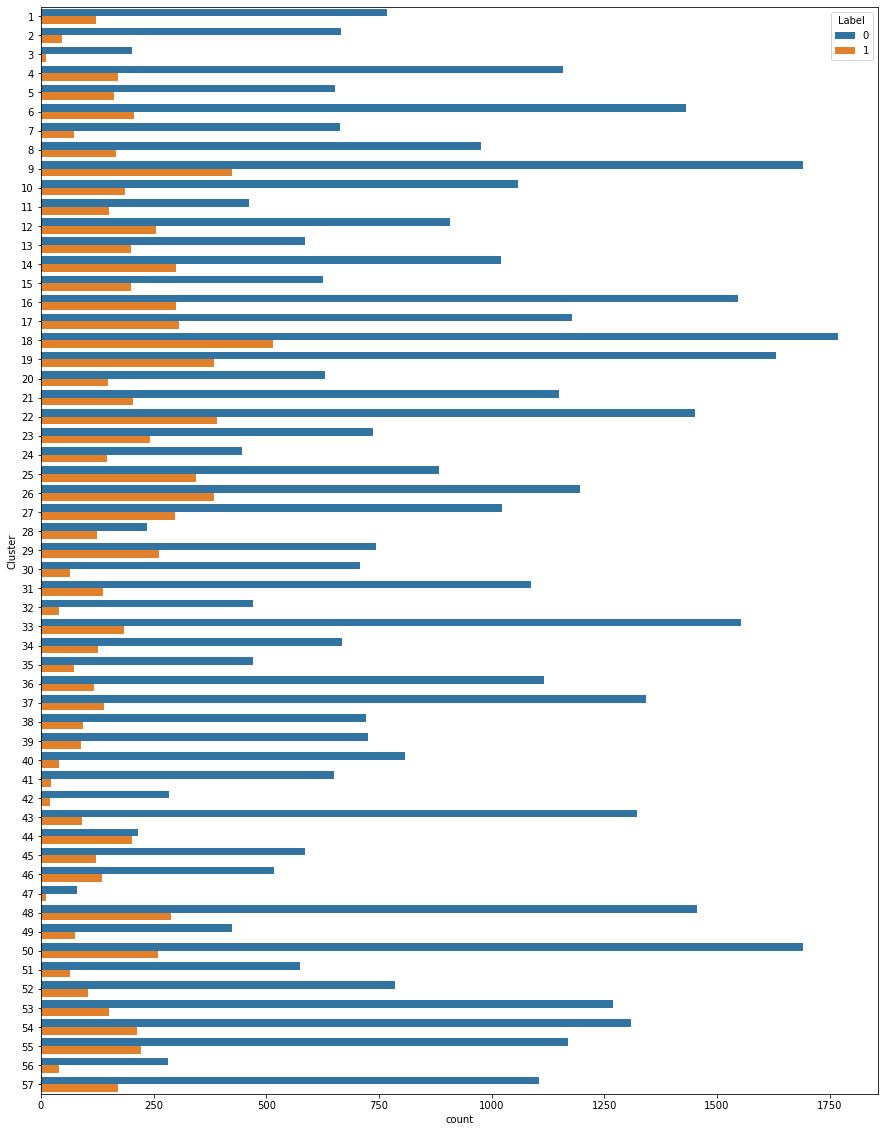

In [121]:
df_shap_2019['Code'] = lst_2019_cd
df_shap_2019['Date'] = lst_2019_dt
df_shap_2019['Label'] = df_data2019_Y[0]
df_shap_2019['Cluster'] = cut_tree_avg_shap_2019
df_shap_2019 = df_shap_2019[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]

# tsne feature 추가 
df_shap_2019['component1'] = np_tsne_shap_2019[:, 0]
df_shap_2019['component2'] = np_tsne_shap_2019[:, 1]

df_shap_2019.head()
plt.figure(figsize=(15, 20))
sns.countplot(data=df_shap_2019, y='Cluster', hue='Label')

label 1 > 0.25 군집 번호:  Int64Index([13, 25, 28, 29, 44], dtype='int64', name='Cluster')


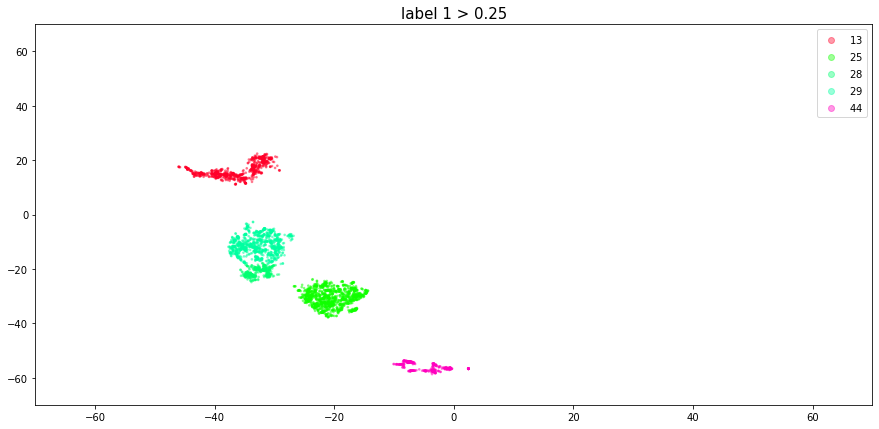

In [122]:
df_shap_2019_1 = label_1_clustering_plot(df_shap_2019, xlim=70,ylim=70, ratio=0.25)

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

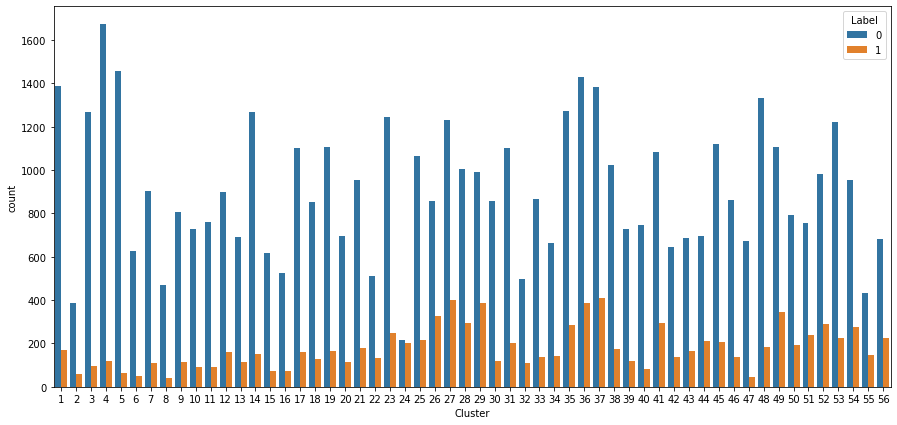

In [112]:
df_shap_2019['Code'] = lst_2019_cd
df_shap_2019['Date'] = lst_2019_dt
df_shap_2019['Label'] = df_data2019_Y[0]
df_shap_2019['Cluster'] = cut_tree_ward_shap_2019
df_shap_2019 = df_shap_2019[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_shap_2019.head()
sns.countplot(data=df_shap_2019, x='Cluster', hue='Label')

===start shap value===
===start shap value===


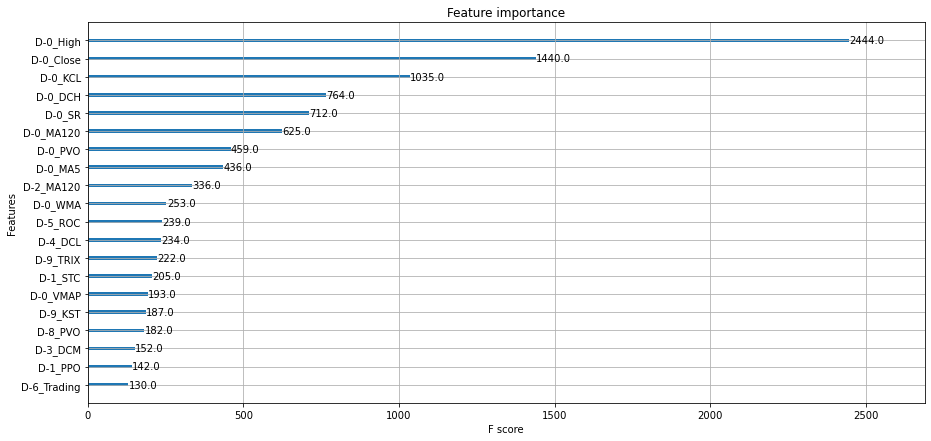

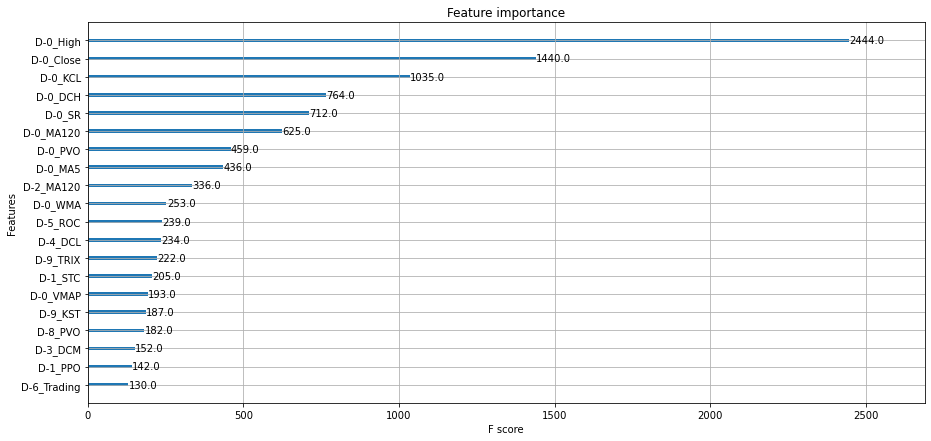

In [123]:
 xgb_importance(df_shap_2019, df_shap_2019_1, year=2019, mode='load')
xgb_importance(df_shap_2019, df_shap_2019_1, year=2019, mode='load') 

### complete_

군집의 개수: 57


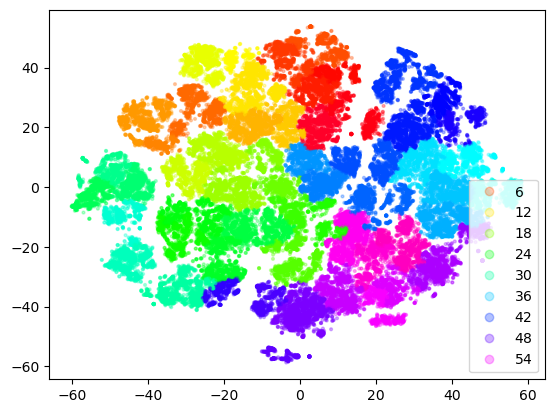

In [89]:
import pickle
with open('./year_data/clusters_shap_2019.pickle', 'rb') as f:
    clusters_shap_2019 = pickle.load(f)
    
cut_tree_shap_2019=fcluster_plot(np_clusters=clusters_shap_2019, np_tsne=np_tsne_shap_2019, t=20) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

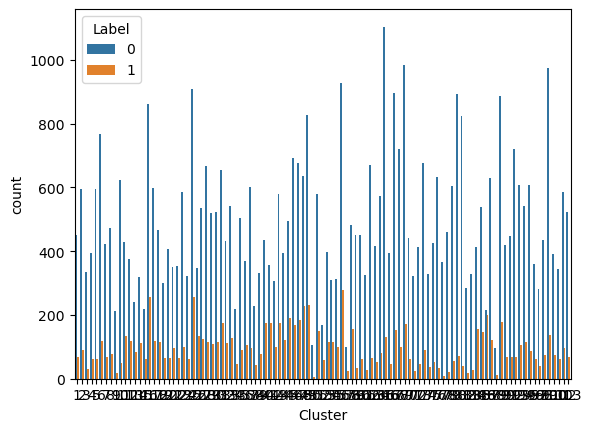

In [47]:
df_shap_2019['Code'] = lst_2019_cd
df_shap_2019['Date'] = lst_2019_dt
df_shap_2019['Label'] = df_data2019_Y[0]
df_shap_2019['Cluster'] = cut_tree_shap_2019
df_shap_2019 = df_shap_2019[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_shap_2019.head()
sns.countplot(data=df_shap_2019, x='Cluster', hue='Label')

## [shap] 2020

### tsne

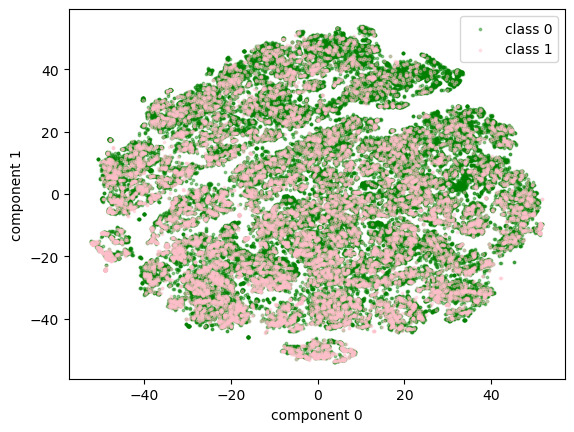

In [48]:
import pickle
with open('./year_data/np_tsne_shap_2020.pickle', 'rb') as f:
    np_tsne_shap_2020 = pickle.load(f)
    
tsne_plot(np_tsne=np_tsne_shap_2020, df_data_Y=df_data2020_Y)

### average

군집의 개수: 22


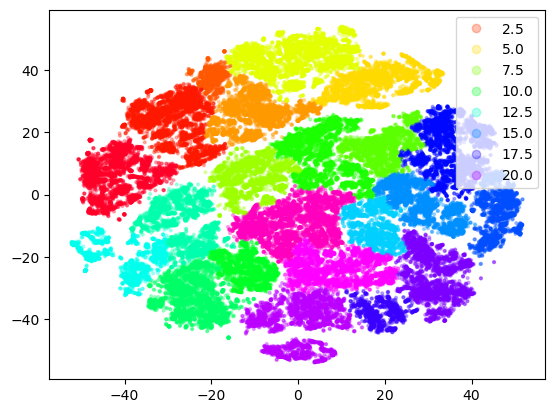

In [49]:
import pickle
with open('./year_data/clusters_avg_shap_2020.pickle', 'rb') as f:
    clusters_avg_shap_2020 = pickle.load(f)
    
cut_tree_avg_shap_2020=fcluster_plot(np_clusters=clusters_avg_shap_2020, np_tsne=np_tsne_shap_2020, t=15) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

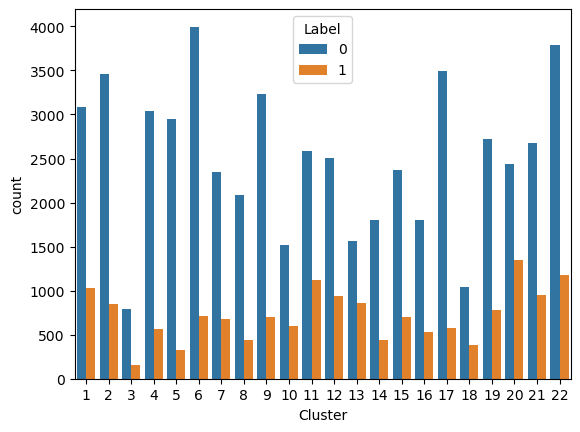

In [50]:
df_shap_2020['Code'] = lst_2020_cd
df_shap_2020['Date'] = lst_2020_dt
df_shap_2020['Label'] = df_data2020_Y[0]
df_shap_2020['Cluster'] = cut_tree_avg_shap_2020
df_shap_2020 = df_shap_2020[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_shap_2020.head()
sns.countplot(data=df_shap_2020, x='Cluster', hue='Label')

### ward

군집의 개수: 792


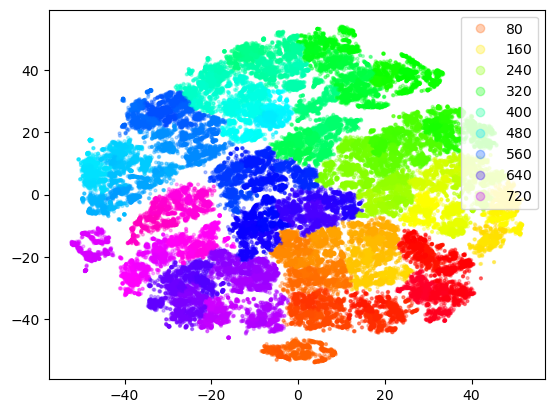

In [51]:
import pickle
with open('./year_data/clusters_ward_shap_2020.pickle', 'rb') as f:
    clusters_ward_shap_2020 = pickle.load(f)
    
cut_tree_ward_shap_2020=fcluster_plot(np_clusters=clusters_ward_shap_2020, np_tsne=np_tsne_shap_2020, t=15) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

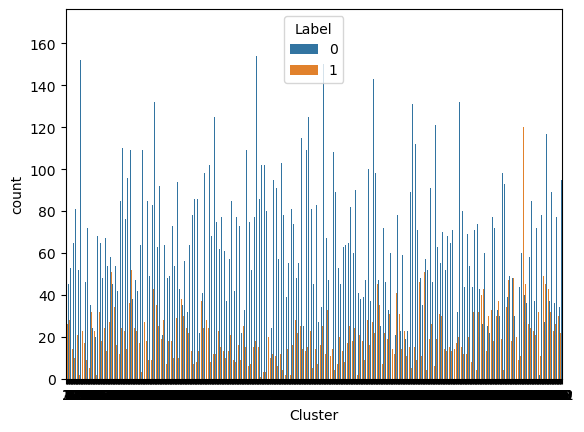

In [52]:
df_shap_2020['Code'] = lst_2020_cd
df_shap_2020['Date'] = lst_2020_dt
df_shap_2020['Label'] = df_data2020_Y[0]
df_shap_2020['Cluster'] = cut_tree_ward_shap_2020
df_shap_2020 = df_shap_2020[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_shap_2020.head()
sns.countplot(data=df_shap_2020, x='Cluster', hue='Label')

### complete_

군집의 개수: 97


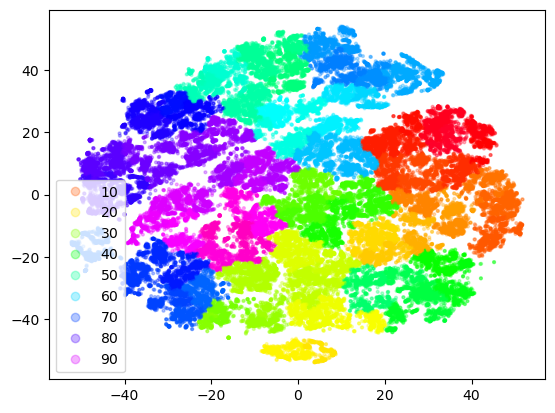

In [53]:
import pickle
with open('./year_data/clusters_shap_2020.pickle', 'rb') as f:
    clusters_shap_2020 = pickle.load(f)
    
cut_tree_shap_2020=fcluster_plot(np_clusters=clusters_shap_2020, np_tsne=np_tsne_shap_2020, t=15) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

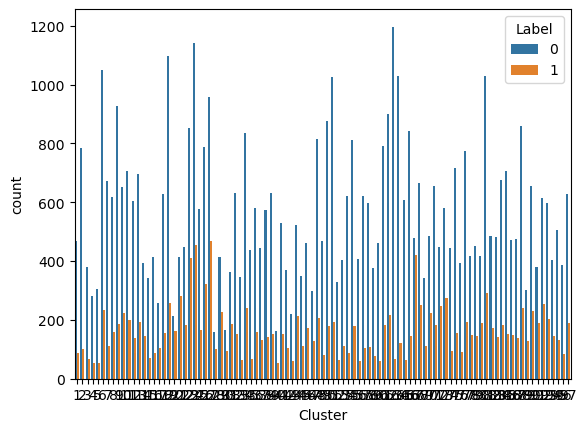

In [54]:
df_shap_2020['Code'] = lst_2020_cd
df_shap_2020['Date'] = lst_2020_dt
df_shap_2020['Label'] = df_data2020_Y[0]
df_shap_2020['Cluster'] = cut_tree_shap_2020
df_shap_2020 = df_shap_2020[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_shap_2020.head()
sns.countplot(data=df_shap_2020, x='Cluster', hue='Label')

## [shap] 2021

### tsne

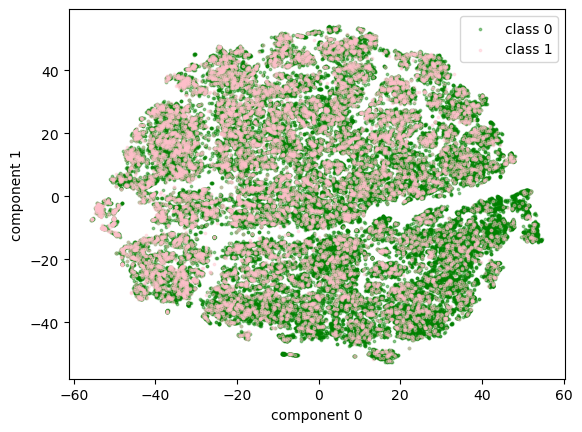

In [55]:
import pickle
with open('./year_data/np_tsne_shap_2021.pickle', 'rb') as f:
    np_tsne_shap_2021 = pickle.load(f)
    
tsne_plot(np_tsne=np_tsne_shap_2021, df_data_Y=df_data2021_Y)

### average

군집의 개수: 26


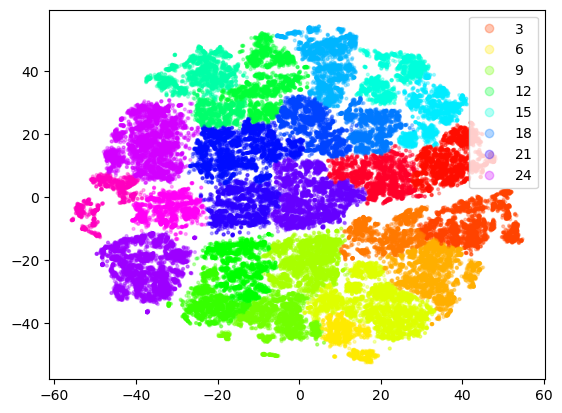

In [56]:
import pickle
with open('./year_data/clusters_avg_shap_2021.pickle', 'rb') as f:
    clusters_avg_shap_2021 = pickle.load(f)
    
cut_tree_avg_shap_2021=fcluster_plot(np_clusters=clusters_avg_shap_2021, np_tsne=np_tsne_shap_2021, t=15) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

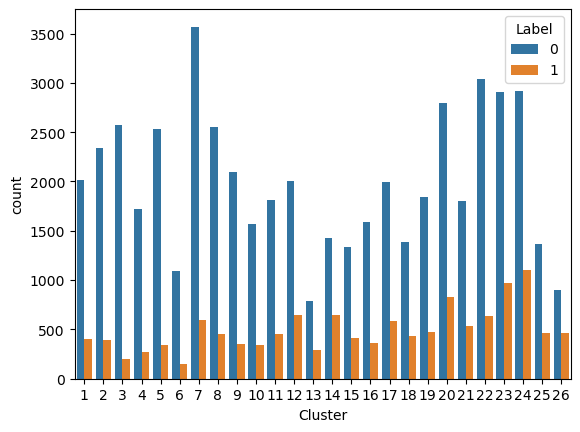

In [57]:
df_shap_2021['Code'] = lst_2021_cd
df_shap_2021['Date'] = lst_2021_dt
df_shap_2021['Label'] = df_data2021_Y[0]
df_shap_2021['Cluster'] = cut_tree_avg_shap_2021
df_shap_2021 = df_shap_2021[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_shap_2021.head()
sns.countplot(data=df_shap_2021, x='Cluster', hue='Label')

### ward

군집의 개수: 774


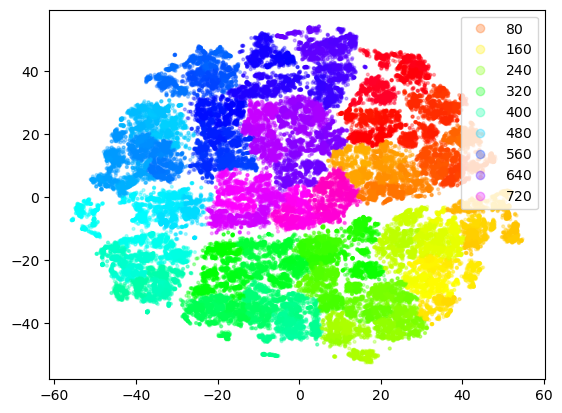

In [58]:
import pickle
with open('./year_data/clusters_ward_shap_2021.pickle', 'rb') as f:
    clusters_ward_shap_2021 = pickle.load(f)
    
cut_tree_ward_shap_2021=fcluster_plot(np_clusters=clusters_ward_shap_2021, np_tsne=np_tsne_shap_2021, t=15) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

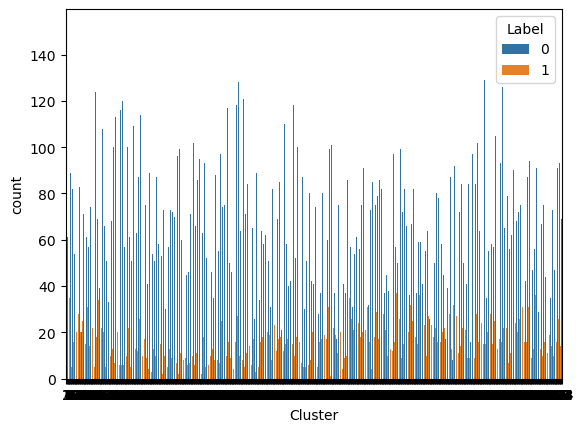

In [59]:
df_shap_2021['Code'] = lst_2021_cd
df_shap_2021['Date'] = lst_2021_dt
df_shap_2021['Label'] = df_data2021_Y[0]
df_shap_2021['Cluster'] = cut_tree_ward_shap_2021
df_shap_2021 = df_shap_2021[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_shap_2021.head()
sns.countplot(data=df_shap_2021, x='Cluster', hue='Label')

### complete_

군집의 개수: 108


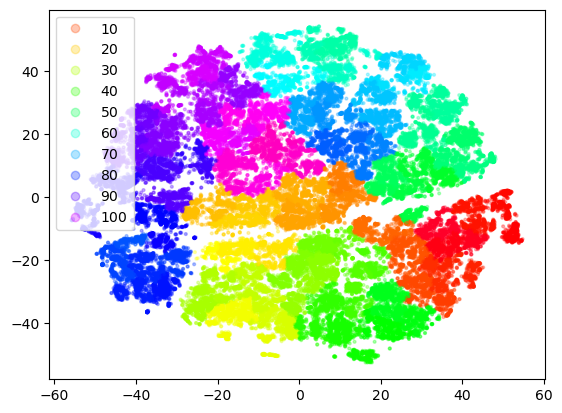

In [60]:
import pickle
with open('./year_data/clusters_shap_2021.pickle', 'rb') as f:
    clusters_shap_2021 = pickle.load(f)
    
cut_tree_shap_2021=fcluster_plot(np_clusters=clusters_shap_2021, np_tsne=np_tsne_shap_2021, t=15) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

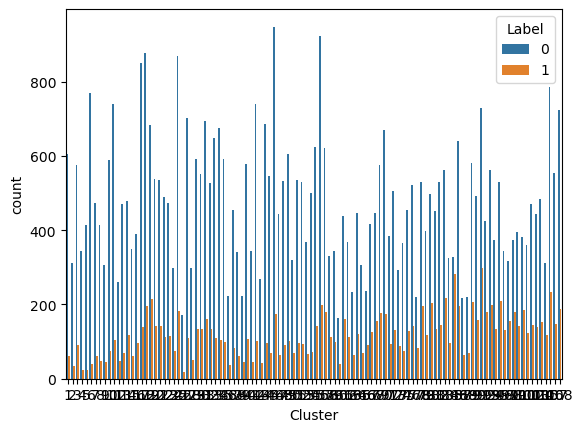

In [61]:
df_shap_2021['Code'] = lst_2021_cd
df_shap_2021['Date'] = lst_2021_dt
df_shap_2021['Label'] = df_data2021_Y[0]
df_shap_2021['Cluster'] = cut_tree_shap_2021
df_shap_2021 = df_shap_2021[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_shap_2021.head()
sns.countplot(data=df_shap_2021, x='Cluster', hue='Label')

## [origin] 2019

### tsne

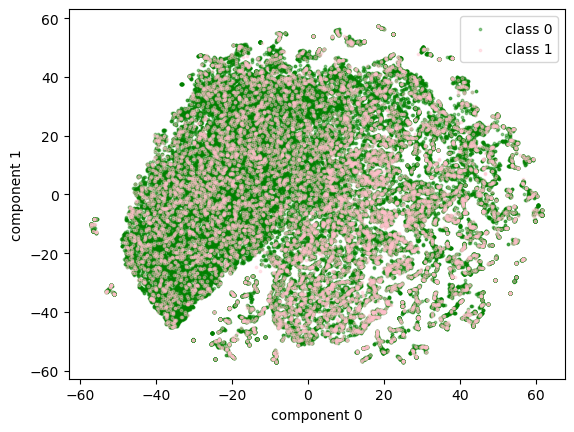

In [62]:
import pickle
with open('./year_data/np_tsne_2019.pickle', 'rb') as f:
    np_tsne_2019 = pickle.load(f)
    
tsne_plot(np_tsne=np_tsne_2019, df_data_Y=df_data2019_Y)

### average

군집의 개수: 33


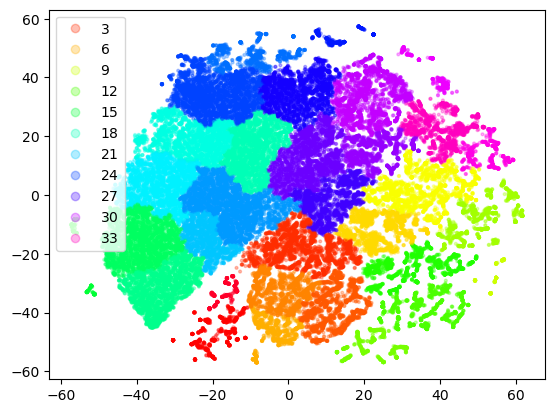

In [63]:
import pickle
with open('./year_data/clusters_avg_2019.pickle', 'rb') as f:
    clusters_avg_2019 = pickle.load(f)
    
cut_tree_avg_2019=fcluster_plot(np_clusters=clusters_avg_2019, np_tsne=np_tsne_2019, t=15) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

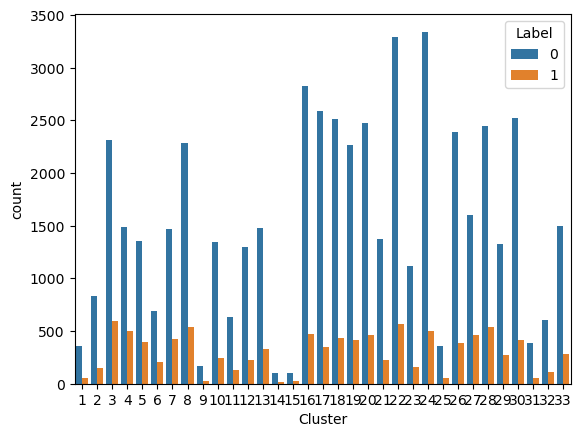

In [64]:
df_2019 = pd.DataFrame(data2019_X)
df_2019.columns = lst_col_info
df_2019['Code'] = lst_2019_cd
df_2019['Date'] = lst_2019_dt
df_2019['Label'] = df_data2019_Y[0]
df_2019['Cluster'] = cut_tree_avg_2019
df_2019 = df_2019[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_2019.head()
sns.countplot(data=df_2019, x='Cluster', hue='Label')

### ward

군집의 개수: 845


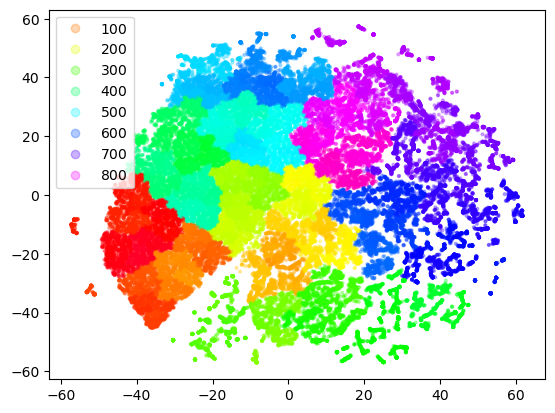

In [65]:
import pickle
with open('./year_data/clusters_ward_2019.pickle', 'rb') as f:
    clusters_ward_2019 = pickle.load(f)
    
cut_tree_ward_2019=fcluster_plot(np_clusters=clusters_ward_2019, np_tsne=np_tsne_2019, t=15) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

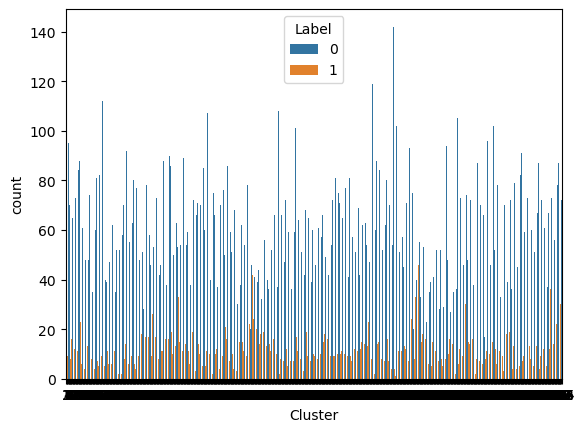

In [66]:
df_2019['Code'] = lst_2019_cd
df_2019['Date'] = lst_2019_dt
df_2019['Label'] = df_data2019_Y[0]
df_2019['Cluster'] = cut_tree_ward_2019
df_2019 = df_2019[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_2019.head()
sns.countplot(data=df_2019, x='Cluster', hue='Label')

### complete_

군집의 개수: 123


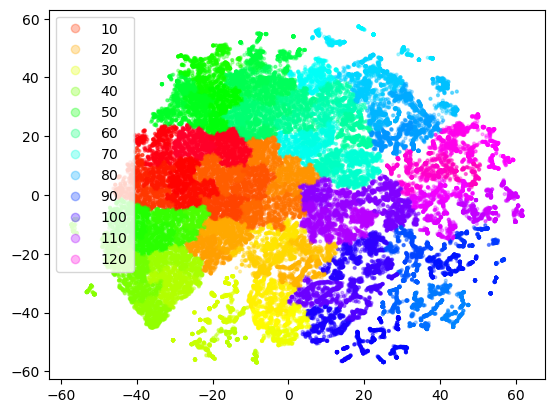

In [67]:
import pickle
with open('./year_data/clusters_2019.pickle', 'rb') as f:
    clusters_2019 = pickle.load(f)
    
cut_tree_2019=fcluster_plot(np_clusters=clusters_2019, np_tsne=np_tsne_2019, t=15) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

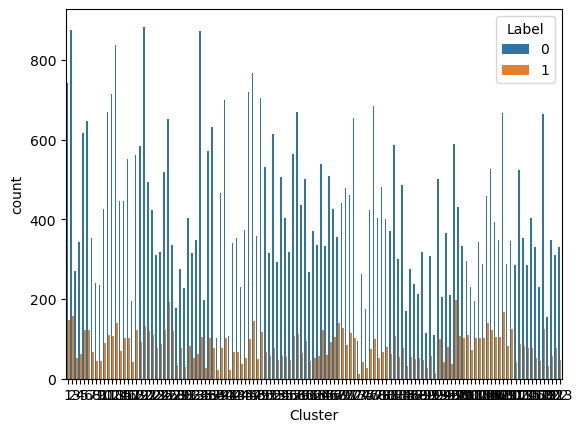

In [68]:
df_2019['Code'] = lst_2019_cd
df_2019['Date'] = lst_2019_dt
df_2019['Label'] = df_data2019_Y[0]
df_2019['Cluster'] = cut_tree_2019
df_2019 = df_2019[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_2019.head()
sns.countplot(data=df_2019, x='Cluster', hue='Label')

## [origin] 2020

### tsne

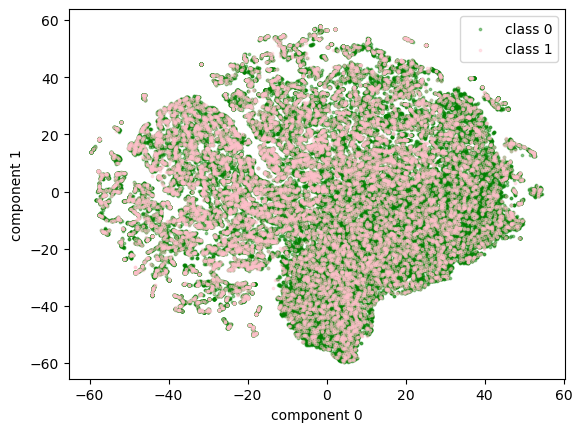

In [69]:
import pickle
with open('./year_data/np_tsne_2020.pickle', 'rb') as f:
    np_tsne_2020 = pickle.load(f)
    
tsne_plot(np_tsne=np_tsne_2020, df_data_Y=df_data2020_Y)

### average

군집의 개수: 30


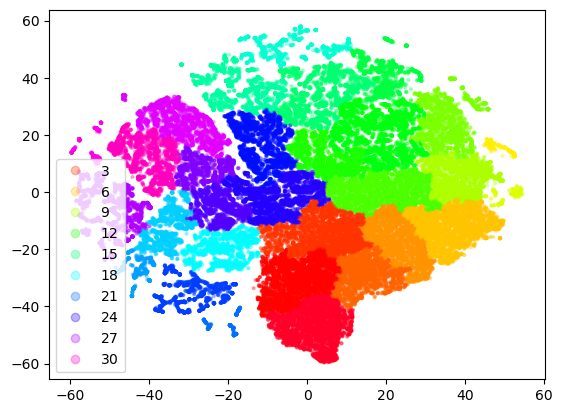

In [70]:
import pickle
with open('./year_data/clusters_avg_2020.pickle', 'rb') as f:
    clusters_avg_2020 = pickle.load(f)
    
cut_tree_avg_2020=fcluster_plot(np_clusters=clusters_avg_2020, np_tsne=np_tsne_2020, t=15) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

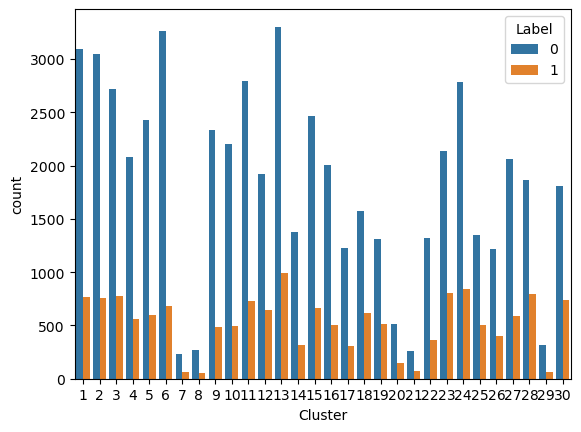

In [71]:
df_2020 = pd.DataFrame(data2020_X)
df_2020.columns = lst_col_info
df_2020['Code'] = lst_2020_cd
df_2020['Date'] = lst_2020_dt
df_2020['Label'] = df_data2020_Y[0]
df_2020['Cluster'] = cut_tree_avg_2020
df_2020 = df_2020[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_2020.head()
sns.countplot(data=df_2020, x='Cluster', hue='Label')

### ward

군집의 개수: 886


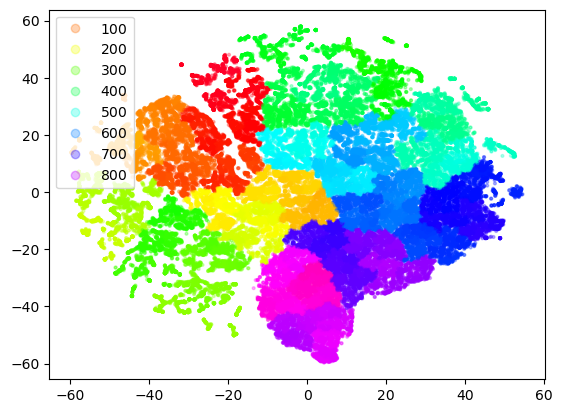

In [72]:
import pickle
with open('./year_data/clusters_ward_2020.pickle', 'rb') as f:
    clusters_ward_2020 = pickle.load(f)
    
cut_tree_ward_2020=fcluster_plot(np_clusters=clusters_ward_2020, np_tsne=np_tsne_2020, t=15) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

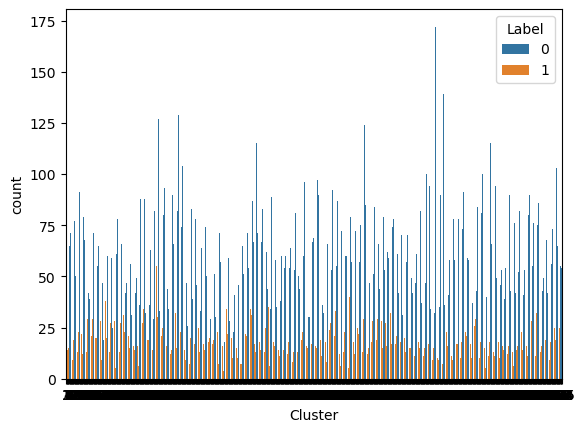

In [73]:
df_2020['Code'] = lst_2020_cd
df_2020['Date'] = lst_2020_dt
df_2020['Label'] = df_data2020_Y[0]
df_2020['Cluster'] = cut_tree_ward_2020
df_2020 = df_2020[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_2020.head()
sns.countplot(data=df_2020, x='Cluster', hue='Label')

### complete_

군집의 개수: 113


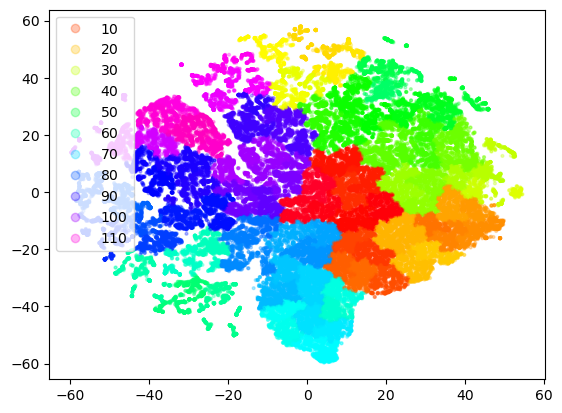

In [74]:
import pickle
with open('./year_data/clusters_2020.pickle', 'rb') as f:
    clusters_2020 = pickle.load(f)
    
cut_tree_2020=fcluster_plot(np_clusters=clusters_2020, np_tsne=np_tsne_2020, t=15) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

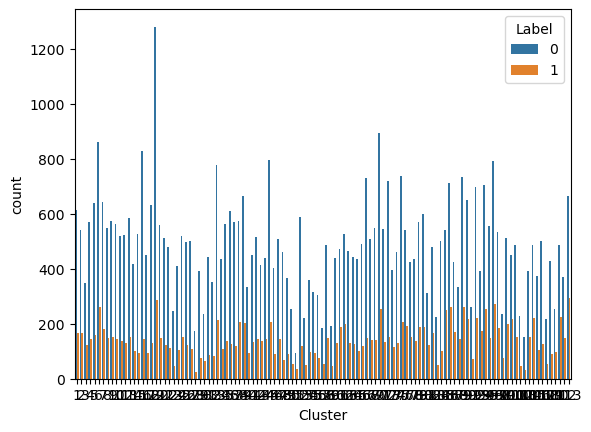

In [75]:
df_2020['Code'] = lst_2020_cd
df_2020['Date'] = lst_2020_dt
df_2020['Label'] = df_data2020_Y[0]
df_2020['Cluster'] = cut_tree_2020
df_2020 = df_2020[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_2020.head()
sns.countplot(data=df_2020, x='Cluster', hue='Label')

## [origin] 2021

### tsne

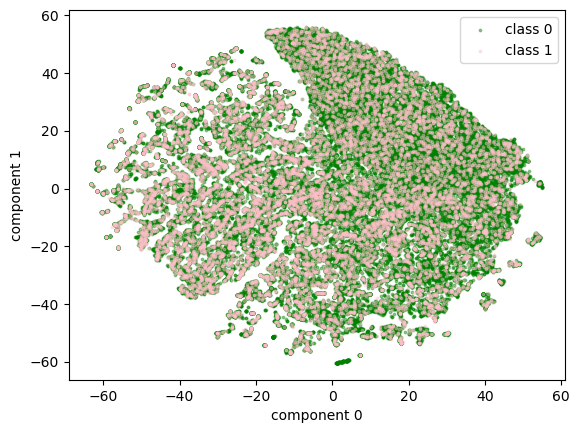

In [76]:
import pickle
with open('./year_data/np_tsne_2021.pickle', 'rb') as f:
    np_tsne_2021 = pickle.load(f)
    
tsne_plot(np_tsne=np_tsne_2021, df_data_Y=df_data2021_Y)

### average

군집의 개수: 32


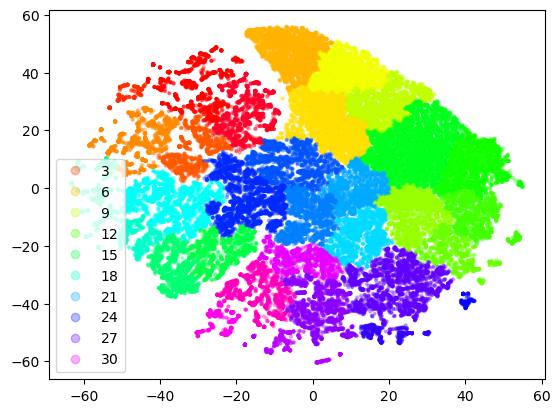

In [77]:
import pickle
with open('./year_data/clusters_avg_2021.pickle', 'rb') as f:
    clusters_avg_2021 = pickle.load(f)
    
cut_tree_avg_2021=fcluster_plot(np_clusters=clusters_avg_2021, np_tsne=np_tsne_2021, t=15) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

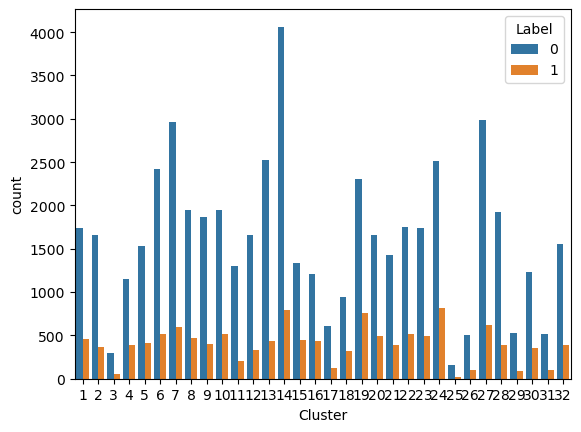

In [78]:
df_2021 = pd.DataFrame(data2021_X)
df_2021.columns = lst_col_info
df_2021['Code'] = lst_2021_cd
df_2021['Date'] = lst_2021_dt
df_2021['Label'] = df_data2021_Y[0]
df_2021['Cluster'] = cut_tree_avg_2021
df_2021 = df_2021[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_2021.head()
sns.countplot(data=df_2021, x='Cluster', hue='Label')

### ward

군집의 개수: 878


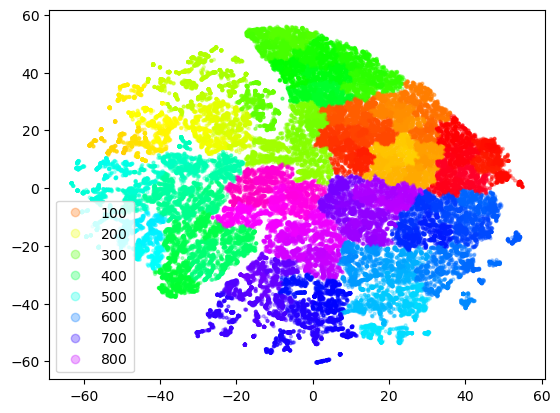

In [79]:
import pickle
with open('./year_data/clusters_ward_2021.pickle', 'rb') as f:
    clusters_ward_2021 = pickle.load(f)
    
cut_tree_ward_2021=fcluster_plot(np_clusters=clusters_ward_2021, np_tsne=np_tsne_2021, t=15) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

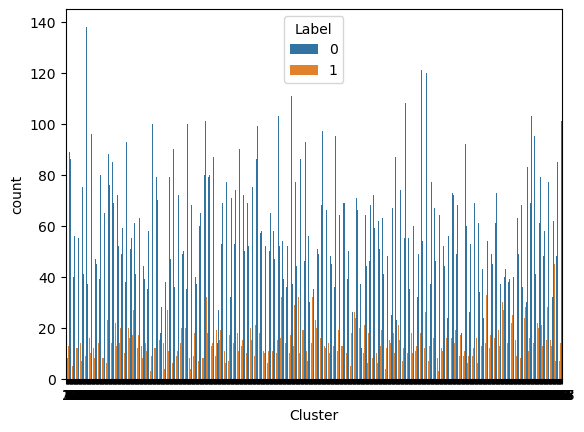

In [80]:
df_2021['Code'] = lst_2021_cd
df_2021['Date'] = lst_2021_dt
df_2021['Label'] = df_data2021_Y[0]
df_2021['Cluster'] = cut_tree_ward_2021
df_2021 = df_2021[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_2021.head()
sns.countplot(data=df_2021, x='Cluster', hue='Label')

### complete_

군집의 개수: 120


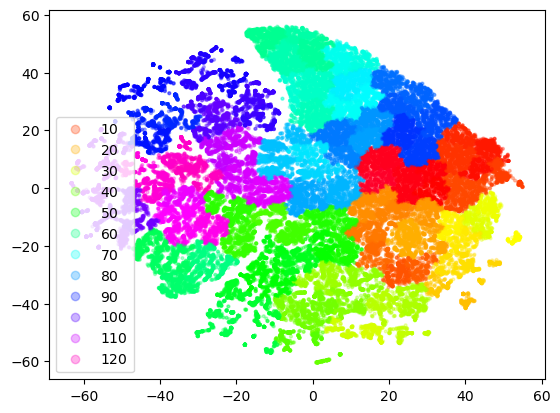

In [81]:
import pickle
with open('./year_data/clusters_2021.pickle', 'rb') as f:
    clusters_2021 = pickle.load(f)
    
cut_tree_2021=fcluster_plot(np_clusters=clusters_2021, np_tsne=np_tsne_2021, t=15) # t가 작을수록 군집 개수 증가

##### 군집 별 데이터(label) 확인

<AxesSubplot:xlabel='Cluster', ylabel='count'>

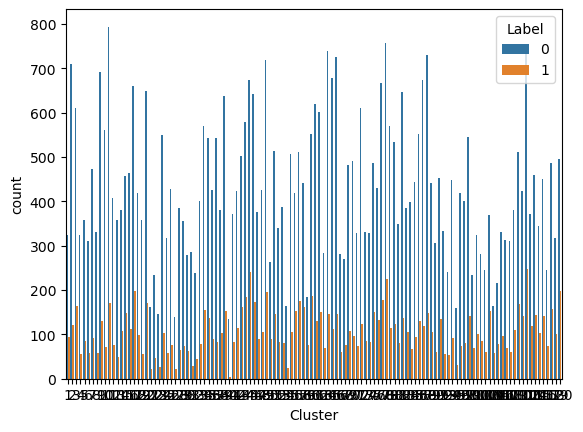

In [82]:
df_2021['Code'] = lst_2021_cd
df_2021['Date'] = lst_2021_dt
df_2021['Label'] = df_data2021_Y[0]
df_2021['Cluster'] = cut_tree_2021
df_2021 = df_2021[['Code', 'Date', 'Cluster']+lst_col_info+['Label']]
df_2021.head()
sns.countplot(data=df_2021, x='Cluster', hue='Label')

---------